In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader import *
from transformer import *

# Model definition

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [4]:
def plot_training(history, marker=None):
    # put everything on cpu
    for key, value in history.items():
        history[key] = [element.cpu() if isinstance(element, torch.Tensor) else element for element in value]

    plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training loss')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_loss'] + history['val_loss'])
        y_max = max(history['train_loss'] + history['val_loss'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training metric')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_acc'] + history['val_acc'])
        y_max = max(history['train_acc'] + history['val_acc'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.show()

In [5]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def train(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history)

    return history

def train_save_best(model, modelNum, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': [],
               'learning_rate': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    noOfBatches = len(iterator)
    train_first = int(noOfBatches / 2)

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            if modelNum == "first" and i >= train_first:
                continue
            elif modelNum == "second" and i < train_first:
                continue
            
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            if modelNum == "first":
                epoch_acc += accuracy / train_first
            elif modelNum == "second":
                epoch_acc += accuracy / (noOfBatches - train_first)
                
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)
        
        scheduler.step(val_loss)

        # save data
        with torch.no_grad():
            current_lr = optimizer.param_groups[0]['lr']

            for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc, current_lr]):
                history[key].append(value)

            # save best model (w.r.t validation loss)
            if val_loss < best_model_score:
                best_model = model.state_dict()
                best_model_score = val_loss
                best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}, \
              Learning Rate : {optimizer.param_groups[0]['lr'] :.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score

# Import data

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
# data = pd.concat([pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1'),
#                   pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')])
data = pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')
# convert string label to binary (int) label (spam:1, non-spam:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == "positive"))

# train, test, val split
train, valid, test = loader.make_dataset(data)
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=512,
                                                     device=device)
   

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

# Creating the embedding matrix
embedding = torch.load("Models/embedding_16.pt")

dataset initializing start
Tokenizing the data...


c:\Users\atace\OneDrive\Desktop\ETH\9.Semester\Deep Learning\project\Exploring-Model-Fusion-with-Optimal-Transport-on-Transformers\dataloader.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["len"] = data.iloc[:, 0].apply(lambda x : len(self.tokenize(x)))


Length of the data :  29544
0
review       [[CLS], one, of, the, many, silent, comedies, ...
sentiment                                                    0
len                                                        186
Name: 46539, dtype: object


100%|██████████| 2955/2955 [00:00<00:00, 19812.66it/s]


dataset initializing done
Vocabulary Size :  23050


# Training

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


note that dataset is imbalanced -> accuracy is not a good metric

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_4836/3607430489.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:34<00:00,  1.36it/s]
C:\Users\atace\AppData\Local\Temp/ipykernel_4836/3607430489.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.4486               Validation Loss: 0.7225               Train acc: 0.5056,               Val acc: 0.5111,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:43<00:00,  1.08it/s]


Epoch: 2  Train Loss: 0.3902               Validation Loss: 0.8383               Train acc: 0.5186,               Val acc: 0.5066,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:45<00:00,  1.04it/s]


Epoch: 3  Train Loss: 0.3677               Validation Loss: 0.7663               Train acc: 0.5325,               Val acc: 0.5260,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.17it/s]


Epoch: 4  Train Loss: 0.3556               Validation Loss: 0.7261               Train acc: 0.5511,               Val acc: 0.5459,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:37<00:00,  1.26it/s]


Epoch: 5  Train Loss: 0.3405               Validation Loss: 0.7840               Train acc: 0.5748,               Val acc: 0.5280,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:42<00:00,  1.11it/s]


Epoch: 6  Train Loss: 0.3293               Validation Loss: 0.7424               Train acc: 0.6036,               Val acc: 0.5565,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.20it/s]


Epoch: 7  Train Loss: 0.3203               Validation Loss: 0.6898               Train acc: 0.6217,               Val acc: 0.5897,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:41<00:00,  1.13it/s]


Epoch: 8  Train Loss: 0.3017               Validation Loss: 0.7234               Train acc: 0.6572,               Val acc: 0.5975,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:41<00:00,  1.14it/s]


Epoch: 9  Train Loss: 0.2912               Validation Loss: 0.6658               Train acc: 0.6805,               Val acc: 0.6335,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.20it/s]


Epoch: 10  Train Loss: 0.2762               Validation Loss: 0.6198               Train acc: 0.7024,               Val acc: 0.6801,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.17it/s]


Epoch: 11  Train Loss: 0.2581               Validation Loss: 0.6397               Train acc: 0.7354,               Val acc: 0.6728,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:38<00:00,  1.21it/s]


Epoch: 12  Train Loss: 0.2390               Validation Loss: 0.5689               Train acc: 0.7603,               Val acc: 0.7181,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:38<00:00,  1.21it/s]


Epoch: 13  Train Loss: 0.2179               Validation Loss: 0.5380               Train acc: 0.7847,               Val acc: 0.7502,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:38<00:00,  1.21it/s]


Epoch: 14  Train Loss: 0.1937               Validation Loss: 0.5123               Train acc: 0.8198,               Val acc: 0.7695,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:39<00:00,  1.18it/s]


Epoch: 15  Train Loss: 0.1702               Validation Loss: 0.5030               Train acc: 0.8492,               Val acc: 0.7748,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 16  Train Loss: 0.1558               Validation Loss: 0.4968               Train acc: 0.8598,               Val acc: 0.7944,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 17  Train Loss: 0.1432               Validation Loss: 0.4800               Train acc: 0.8780,               Val acc: 0.8062,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 18  Train Loss: 0.1304               Validation Loss: 0.5504               Train acc: 0.8903,               Val acc: 0.7734,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:41<00:00,  1.15it/s]


Epoch: 19  Train Loss: 0.1154               Validation Loss: 0.4847               Train acc: 0.9056,               Val acc: 0.8151,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:41<00:00,  1.14it/s]


Epoch: 20  Train Loss: 0.1024               Validation Loss: 0.4831               Train acc: 0.9173,               Val acc: 0.8168,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.17it/s]


Epoch: 21  Train Loss: 0.0907               Validation Loss: 0.4668               Train acc: 0.9256,               Val acc: 0.8320,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 22  Train Loss: 0.0902               Validation Loss: 0.4872               Train acc: 0.9273,               Val acc: 0.8325,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 23  Train Loss: 0.0791               Validation Loss: 0.5056               Train acc: 0.9390,               Val acc: 0.8275,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.17it/s]


Epoch: 24  Train Loss: 0.0755               Validation Loss: 0.4969               Train acc: 0.9407,               Val acc: 0.8284,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 25  Train Loss: 0.0689               Validation Loss: 0.5540               Train acc: 0.9488,               Val acc: 0.8117,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 26  Train Loss: 0.0659               Validation Loss: 0.4958               Train acc: 0.9504,               Val acc: 0.8337,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 27  Train Loss: 0.0618               Validation Loss: 0.5374               Train acc: 0.9549,               Val acc: 0.8290,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 28  Train Loss: 0.0504               Validation Loss: 0.5077               Train acc: 0.9654,               Val acc: 0.8353,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 29  Train Loss: 0.0457               Validation Loss: 0.5045               Train acc: 0.9717,               Val acc: 0.8390,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:40<00:00,  1.16it/s]


Epoch: 30  Train Loss: 0.0451               Validation Loss: 0.5079               Train acc: 0.9708,               Val acc: 0.8387,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:41<00:00,  1.12it/s]


Epoch: 31  Train Loss: 0.0456               Validation Loss: 0.5046               Train acc: 0.9712,               Val acc: 0.8382,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:42<00:00,  1.11it/s]


Epoch: 32  Train Loss: 0.0452               Validation Loss: 0.5128               Train acc: 0.9695,               Val acc: 0.8353,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:54<00:00,  1.15s/it]


Epoch: 33  Train Loss: 0.0447               Validation Loss: 0.5195               Train acc: 0.9731,               Val acc: 0.8429,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:52<00:00,  1.12s/it]


Epoch: 34  Train Loss: 0.0428               Validation Loss: 0.5086               Train acc: 0.9723,               Val acc: 0.8388,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:46<00:00,  1.01it/s]


Epoch: 35  Train Loss: 0.0424               Validation Loss: 0.5136               Train acc: 0.9736,               Val acc: 0.8381,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:47<00:00,  1.01s/it]


Epoch: 36  Train Loss: 0.0429               Validation Loss: 0.5129               Train acc: 0.9733,               Val acc: 0.8382,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:46<00:00,  1.00it/s]


Epoch: 37  Train Loss: 0.0433               Validation Loss: 0.5120               Train acc: 0.9726,               Val acc: 0.8395,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:47<00:00,  1.01s/it]


Epoch: 38  Train Loss: 0.0428               Validation Loss: 0.5141               Train acc: 0.9727,               Val acc: 0.8377,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:49<00:00,  1.06s/it]


Epoch: 39  Train Loss: 0.0407               Validation Loss: 0.5124               Train acc: 0.9760,               Val acc: 0.8387,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:48<00:00,  1.03s/it]


Epoch: 40  Train Loss: 0.0430               Validation Loss: 0.5169               Train acc: 0.9730,               Val acc: 0.8379,               Learning Rate : 0.0000


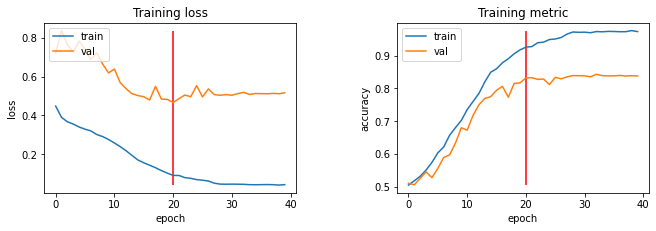

Wall time: 31min 15s


In [8]:
%%time
# train model A
modelA = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)
modelA = modelA.to(device) # put on CPU/GPU

optA = torch.optim.Adam(modelA.parameters(), lr=0.002)
loss_fnA = nn.CrossEntropyLoss()


epochs = 40

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter,
                                                            modelNum = "first",
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelA_IMDB_256_parallelization')

# save history
with open('./Models/history_modelA_IMDB_256_parallelization.txt', 'w') as dat:
    dat.write(str(historyA))

 34%|███▍      | 16/47 [00:00<00:00, 142.83it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_4836/3607430489.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:39<00:00,  1.19it/s] 
C:\Users\atace\AppData\Local\Temp/ipykernel_4836/3607430489.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.4150               Validation Loss: 0.5243               Train acc: 0.5459,               Val acc: 0.7441,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:57<00:00,  1.23s/it]


Epoch: 2  Train Loss: 0.2040               Validation Loss: 0.3968               Train acc: 0.8187,               Val acc: 0.8204,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:57<00:00,  1.23s/it]


Epoch: 3  Train Loss: 0.1520               Validation Loss: 0.3978               Train acc: 0.8692,               Val acc: 0.8318,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:49<00:00,  1.06s/it]


Epoch: 4  Train Loss: 0.1213               Validation Loss: 0.4064               Train acc: 0.9014,               Val acc: 0.8365,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:46<00:00,  1.01it/s]


Epoch: 5  Train Loss: 0.1089               Validation Loss: 0.4011               Train acc: 0.9119,               Val acc: 0.8482,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.06it/s] 


Epoch: 6  Train Loss: 0.0939               Validation Loss: 0.3816               Train acc: 0.9246,               Val acc: 0.8518,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:44<00:00,  1.06it/s]


Epoch: 7  Train Loss: 0.0872               Validation Loss: 0.4072               Train acc: 0.9309,               Val acc: 0.8528,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:47<00:00,  1.01s/it]


Epoch: 8  Train Loss: 0.0809               Validation Loss: 0.4992               Train acc: 0.9365,               Val acc: 0.8199,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:51<00:00,  1.09s/it]


Epoch: 9  Train Loss: 0.0804               Validation Loss: 0.4629               Train acc: 0.9392,               Val acc: 0.8484,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:49<00:00,  1.06s/it]


Epoch: 10  Train Loss: 0.0655               Validation Loss: 0.4486               Train acc: 0.9541,               Val acc: 0.8467,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 11  Train Loss: 0.0566               Validation Loss: 0.4680               Train acc: 0.9580,               Val acc: 0.8430,               Learning Rate : 0.0020


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 12  Train Loss: 0.0520               Validation Loss: 0.5977               Train acc: 0.9647,               Val acc: 0.8122,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:49<00:00,  1.06s/it]


Epoch: 13  Train Loss: 0.0500               Validation Loss: 0.4715               Train acc: 0.9631,               Val acc: 0.8538,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 14  Train Loss: 0.0409               Validation Loss: 0.4793               Train acc: 0.9765,               Val acc: 0.8501,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 15  Train Loss: 0.0371               Validation Loss: 0.4726               Train acc: 0.9783,               Val acc: 0.8533,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 16  Train Loss: 0.0358               Validation Loss: 0.4640               Train acc: 0.9810,               Val acc: 0.8560,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 17  Train Loss: 0.0320               Validation Loss: 0.4797               Train acc: 0.9822,               Val acc: 0.8526,               Learning Rate : 0.0002


100%|██████████| 47/47 [00:50<00:00,  1.08s/it]


Epoch: 18  Train Loss: 0.0328               Validation Loss: 0.4718               Train acc: 0.9808,               Val acc: 0.8565,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 19  Train Loss: 0.0320               Validation Loss: 0.4730               Train acc: 0.9829,               Val acc: 0.8544,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:50<00:00,  1.07s/it]


Epoch: 20  Train Loss: 0.0324               Validation Loss: 0.4723               Train acc: 0.9818,               Val acc: 0.8569,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:52<00:00,  1.11s/it]


Epoch: 21  Train Loss: 0.0323               Validation Loss: 0.4772               Train acc: 0.9840,               Val acc: 0.8539,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 22  Train Loss: 0.0296               Validation Loss: 0.4759               Train acc: 0.9848,               Val acc: 0.8542,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:49<00:00,  1.05s/it]


Epoch: 23  Train Loss: 0.0312               Validation Loss: 0.4753               Train acc: 0.9827,               Val acc: 0.8569,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:49<00:00,  1.06s/it]


Epoch: 24  Train Loss: 0.0310               Validation Loss: 0.4760               Train acc: 0.9833,               Val acc: 0.8540,               Learning Rate : 0.0000


100%|██████████| 47/47 [01:06<00:00,  1.42s/it]


Epoch: 25  Train Loss: 0.0322               Validation Loss: 0.4744               Train acc: 0.9827,               Val acc: 0.8550,               Learning Rate : 0.0000


100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


Epoch: 26  Train Loss: 0.0321               Validation Loss: 0.4743               Train acc: 0.9824,               Val acc: 0.8556,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:56<00:00,  1.21s/it]


Epoch: 27  Train Loss: 0.0314               Validation Loss: 0.4813               Train acc: 0.9828,               Val acc: 0.8563,               Learning Rate : 0.0000


100%|██████████| 47/47 [01:23<00:00,  1.77s/it]


Epoch: 28  Train Loss: 0.0297               Validation Loss: 0.4762               Train acc: 0.9853,               Val acc: 0.8562,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:53<00:00,  1.15s/it]


Epoch: 29  Train Loss: 0.0330               Validation Loss: 0.4781               Train acc: 0.9818,               Val acc: 0.8557,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:57<00:00,  1.23s/it]


Epoch: 30  Train Loss: 0.0311               Validation Loss: 0.4738               Train acc: 0.9838,               Val acc: 0.8569,               Learning Rate : 0.0000


100%|██████████| 47/47 [01:06<00:00,  1.42s/it]


Epoch: 31  Train Loss: 0.0314               Validation Loss: 0.4749               Train acc: 0.9845,               Val acc: 0.8570,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:59<00:00,  1.27s/it]


Epoch: 32  Train Loss: 0.0312               Validation Loss: 0.4820               Train acc: 0.9840,               Val acc: 0.8554,               Learning Rate : 0.0000


100%|██████████| 47/47 [01:08<00:00,  1.47s/it]


Epoch: 33  Train Loss: 0.0331               Validation Loss: 0.4729               Train acc: 0.9816,               Val acc: 0.8570,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:55<00:00,  1.18s/it]


Epoch: 34  Train Loss: 0.0311               Validation Loss: 0.4698               Train acc: 0.9841,               Val acc: 0.8580,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:54<00:00,  1.15s/it]


Epoch: 35  Train Loss: 0.0302               Validation Loss: 0.4773               Train acc: 0.9845,               Val acc: 0.8567,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:52<00:00,  1.12s/it]


Epoch: 36  Train Loss: 0.0324               Validation Loss: 0.4783               Train acc: 0.9837,               Val acc: 0.8562,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:48<00:00,  1.04s/it]


Epoch: 37  Train Loss: 0.0308               Validation Loss: 0.4759               Train acc: 0.9843,               Val acc: 0.8564,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:47<00:00,  1.01s/it]


Epoch: 38  Train Loss: 0.0314               Validation Loss: 0.4766               Train acc: 0.9836,               Val acc: 0.8562,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:52<00:00,  1.13s/it]


Epoch: 39  Train Loss: 0.0305               Validation Loss: 0.4804               Train acc: 0.9845,               Val acc: 0.8560,               Learning Rate : 0.0000


100%|██████████| 47/47 [00:56<00:00,  1.21s/it]


Epoch: 40  Train Loss: 0.0330               Validation Loss: 0.4753               Train acc: 0.9818,               Val acc: 0.8565,               Learning Rate : 0.0000


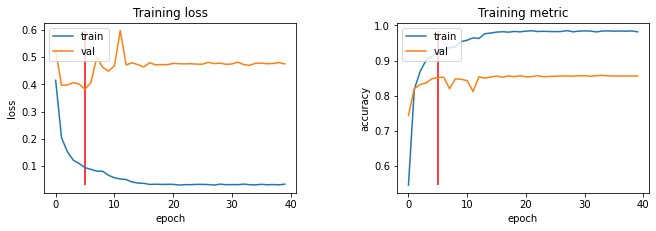

Wall time: 39min 24s


In [9]:
%%time
# train model B
modelB = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)
modelB = modelB.to(device) # put on CPU/GPU

optB = torch.optim.Adam(modelB.parameters(), lr=0.002)
loss_fnB = nn.CrossEntropyLoss()


epochs = 40

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter,
                                                            modelNum="second",
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelB, './Models/modelB_IMDB_256_parallelization')

# save history
with open('./Models/historymodelB_IMDB_256_parallelization.txt', 'w') as dat:
    dat.write(str(historyB))

# Model fusion

### Definitions

In [ ]:
def weight_averaging(*weights):
  with torch.no_grad():
    sum = torch.zeros(weights[0].shape, device=device)
    for weight in weights:
      sum += weight
  return sum / len(weights)

In [ ]:
def linear_averaging(*linears):
  """Averages several linear layers (weights + biases)"""
  with torch.no_grad():
    weights = [linear.weight for linear in linears]
    biases = [linear.bias for linear in linears]

    linear_averaged = torch.nn.Linear(linears[0].in_features, linears[0].out_features, bias=True).to(device)
    linear_averaged.weight, linear_averaged.bias = torch.nn.Parameter(weight_averaging(*weights)), torch.nn.Parameter(weight_averaging(*biases))

  return linear_averaged

In [ ]:
def vanilla_fusion(modelA, modelB):
  # init
  model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

  with torch.no_grad():
    # 1) encoder
    # TODO: smarter method for embedding
    # a) embedding
    weights_A = modelA.encoder.emb.tok_emb.weight
    weights_B = modelB.encoder.emb.tok_emb.weight

    weights_fusion = weight_averaging(weights_A, weights_B) # weights seem to be exactly the same?
    model_fusion.encoder.emb.tok_emb.weight = torch.nn.Parameter(weights_fusion)

    # b) encoder layers
    for i, _ in enumerate(modelA.encoder.layers):
      # i) self-attention (fuse Q, K, V separately) # TODO: check validity of this approach
      # query
      query_A = modelA.encoder.layers[i].attention.w_q
      query_B = modelB.encoder.layers[i].attention.w_q

      query_fusion = linear_averaging(query_A, query_B)
      model_fusion.encoder.layers[i].attention.w_q = query_fusion

      # key
      key_A = modelA.encoder.layers[i].attention.w_k
      key_B = modelB.encoder.layers[i].attention.w_k

      key_fusion = linear_averaging(key_A, key_B)
      model_fusion.encoder.layers[i].attention.w_k = key_fusion

      # value
      value_A = modelA.encoder.layers[i].attention.w_v
      value_B = modelB.encoder.layers[i].attention.w_v

      value_fusion = linear_averaging(value_A, value_B)
      model_fusion.encoder.layers[i].attention.w_v = value_fusion

      # output
      output_A = modelA.encoder.layers[i].attention.w_concat
      output_B = modelB.encoder.layers[i].attention.w_concat

      output_fusion = linear_averaging(output_A, output_B)
      model_fusion.encoder.layers[i].attention.w_concat = output_fusion

      # ii) layer norm 1
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

      # iii) feed-forward network
      # layer 1
      linear_A = modelA.encoder.layers[i].ffn.linear1
      linear_B = modelB.encoder.layers[i].ffn.linear1

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear1 = linear_fusion

      # layer 2
      linear_A = modelA.encoder.layers[i].ffn.linear2
      linear_B = modelB.encoder.layers[i].ffn.linear2

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear2 = linear_fusion

      # iv) layer norm 2
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

    # 2) MLP head
    linear_A = modelA.linear
    linear_B = modelB.linear

    linear_fusion = linear_averaging(linear_A, linear_B)
    model_fusion.linear = linear_fusion

  return model_fusion

In [ ]:
def test_fusion(modelA, modelB, model_fusion):
  # test fusion
  test_loss_A, test_acc_A = validation(modelA, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_B, test_acc_B = validation(modelB, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_fusion, test_acc_fusion = validation(model_fusion, test_iter, None, nn.CrossEntropyLoss(), device)

  # visualize
  fig, ax = plt.subplots()

  metrics_A = [test_loss_A, test_acc_A]
  metrics_B = [test_loss_B, test_acc_B]
  metrics_fusion = [test_loss_fusion, test_acc_fusion]
  metrics = ['loss', 'accuracy']
  x = np.arange(len(metrics)) # positions of bars (1 per metric)
  width = 0.25  # the width of the bars

  rects1 = ax.bar(x - width, metrics_A, width, label='model A')
  rects2 = ax.bar(x, metrics_B, width, label='model B')
  rects3 = ax.bar(x + width, metrics_fusion, width, label='model fusion')

  ax.set_ylabel('Score')
  ax.set_title('Test metrics by models')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.show()

### (Optional) load models

In [ ]:
# load parent models
# TODO: change enc_voc_size back
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

modelA.load_state_dict(torch.load('./Models/modelA'))
modelB.load_state_dict(torch.load('./Models/modelB'))

### Fusion

Vanilla fusion

In [ ]:
model_fusion = vanilla_fusion(modelA, modelB)

Optimal transport

In [ ]:
model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                               enc_voc_size = voc_size,
                               max_len = 256,
                               d_model = 512,
                               ffn_hidden = 2048,
                               n_head = 1,
                               n_layers = 1,
                               drop_prob = 0.1,
                               device = device)

model_fusion.load_state_dict(torch.load('./Models/model_fusion_OT_pre_retraining'))

### Test fusion

Randomly initialiized model for comparison

In [ ]:
# test with new randomly initialized transformer
test_fusion(modelA, modelB, TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device))

Fusion model

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)

### Retraining

In [ ]:
model_name = 'model_fusion_OT_post_retraining'

In [ ]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=0.001)
loss_fn_fusion = nn.CrossEntropyLoss()


epochs = 200
history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=epochs,
                                                                             clip=1,
                                                                             device=device)

In [ ]:
# save model
torch.save(best_model_fusion, f'./Models/{model_name}')

# save history
with open(f'./Models/history_{model_name}.txt', 'w') as dat:
    dat.write(str(history_fusion))

In [ ]:
# load best model (current model is trained on full epochs)
model_fusion.load_state_dict(best_model_fusion)

### Test fusion (after retraining)

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)